In [1]:
import cv2
import random as rd
import numpy as np
import matplotlib.pyplot as plt

from generation_utilities import generate_paper

In [2]:
%load_ext autoreload
%autoreload 2

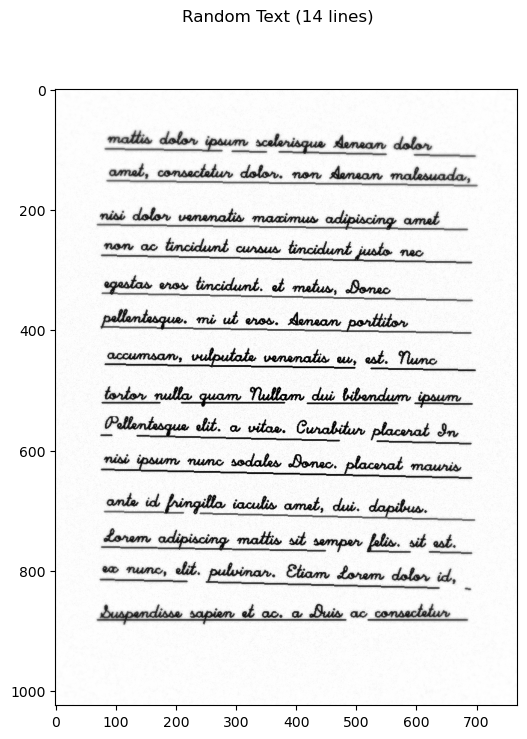

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6.6, 8))
paper, count = generate_paper()
ax.imshow(paper, cmap="gray", vmin=0, vmax=255)
plt.suptitle(f"Random Text ({count} lines)")
plt.show()

In [5]:
def imshow(image, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(6.6, 8))
    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    if title: plt.suptitle(title)
    plt.show()

In [6]:
# Get the input as image
image = paper

In [7]:
# Convert it to grayscale (Though it already is)
gray = image

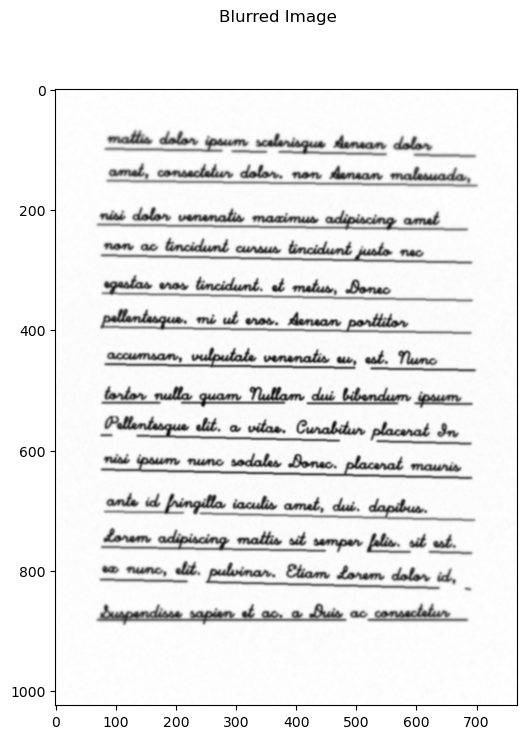

In [8]:
# Apply blurring to reduce noise
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
imshow(blurred, "Blurred Image")

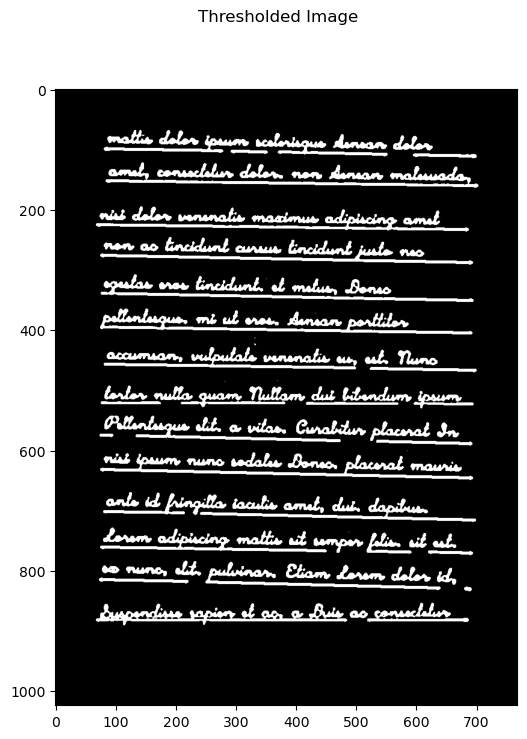

In [9]:
# Quantize the image to get rid of noise
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 5)
imshow(thresh, "Thresholded Image")

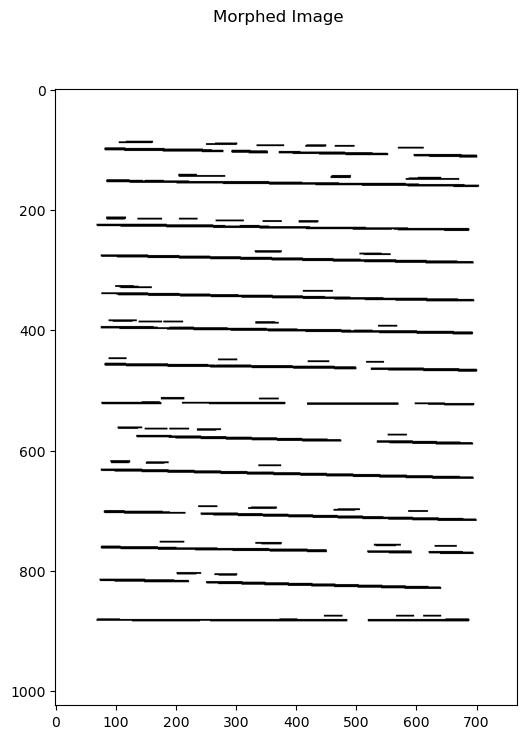

In [10]:
# Identify combed straight structures
kernel_length = gray.shape[1] // 25
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 3))
morphed = 255 - cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel)
imshow(morphed, "Morphed Image")

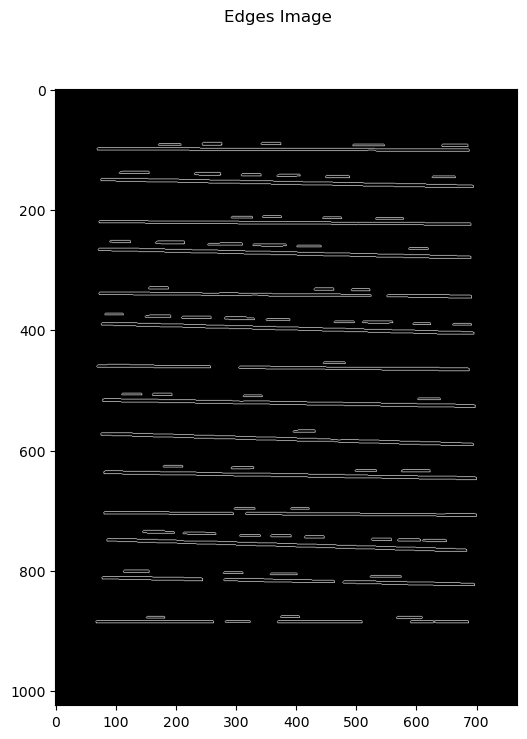

In [112]:
# Apply Canny Edge Detection
edges = cv2.Canny(morphed, 50, 150, apertureSize=3)
imshow(edges, "Edges Image")

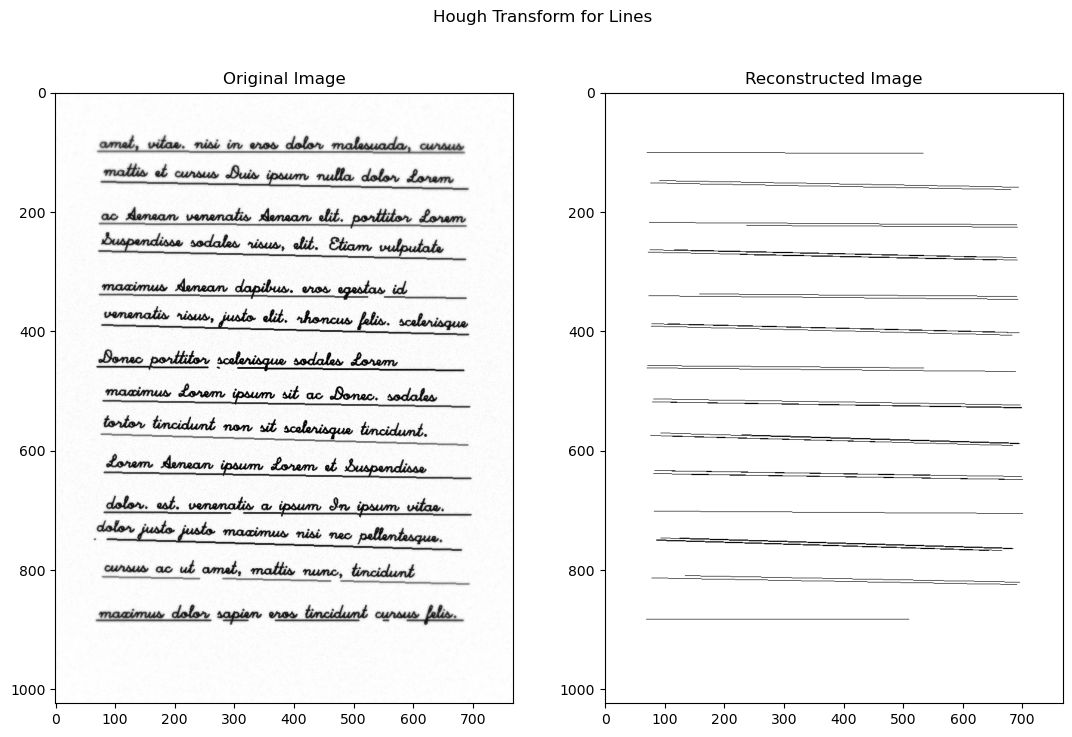

In [119]:
# Apply Hough Transform
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180 / 20,
    threshold=80,
    minLineLength=int(image.shape[1] * 0.5),
    maxLineGap=80
)

reconstruct = np.ones_like(image) * 255

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(reconstruct, (x1, y1), (x2, y2), 0, 1)

fig, axs = plt.subplots(1, 2, figsize=(13, 8))
axs[0].set_title("Original Image")
axs[0].imshow(image, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Reconstructed Image")
axs[1].imshow(reconstruct, cmap="gray", vmin=0, vmax=255)
plt.suptitle("Hough Transform for Lines")
plt.show()

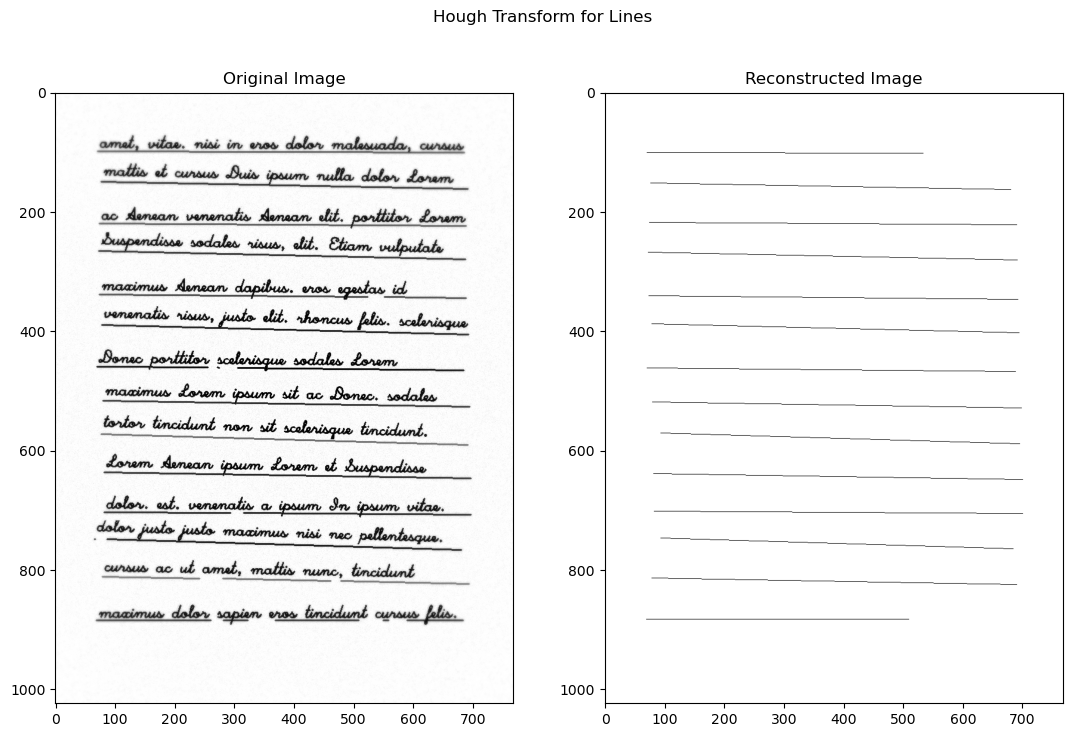

In [121]:
horizontal_lines = []

for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    if abs(angle) < 5:
        horizontal_lines.append((x1, y1, x2, y2))

line_intercepts = [((y1 + y2) / 2, x1, y1, x2, y2) for (x1, y1, x2, y2) in horizontal_lines]
line_intercepts.sort(key=lambda x: x[0])

merged_lines = []
tolerance = 12  # vertical pixels

for info in line_intercepts:
    y_avg, x1, y1, x2, y2 = info
    if not merged_lines:
        merged_lines.append(info)
    else:
        last_y = merged_lines[-1][0]

        if abs(y_avg - last_y) < tolerance:
            prev = merged_lines[-1]
            prev_len = abs(prev[3] - prev[1])
            curr_len = abs(x2 - x1)

            if curr_len > prev_len:
                merged_lines[-1] = info
        else:
            merged_lines.append(info)

reconstruct = np.ones_like(image) * 255

for line in merged_lines:
    _, x1, y1, x2, y2 = line
    cv2.line(reconstruct, (x1, y1), (x2, y2), 0, 1)

fig, axs = plt.subplots(1, 2, figsize=(13, 8))
axs[0].set_title("Original Image")
axs[0].imshow(image, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Reconstructed Image")
axs[1].imshow(reconstruct, cmap="gray", vmin=0, vmax=255)
plt.suptitle("Hough Transform for Lines")
plt.show()